# 02 Mapping Assistant

Interactive tool for reviewing **unmapped ministries/categories** and assigning them to normalized categories.

### How it works:
1. Loads `data/unmapped_categories.csv` (newly discovered ministries)
2. Loads `data/mappings_cleaned.csv` (current mapping table)
3. Displays unmapped ministries and lets you assign normalized categories interactively
4. Saves results back to `mappings_cleaned.csv` **with backups**

---

In [93]:
from pathlib import Path
root = Path('/home/ampersand/iceland-spending-ai')
data_dir = root / 'data'
structured_dir = data_dir / 'structured_csvs'
normalized_dir = data_dir / 'normalized'
mappings_file = data_dir / 'mappings_cleaned.csv'
unmapped_output = data_dir / 'unmapped_after_propagation.csv'
unmapped_path = data_dir / 'unmapped_categories.csv'

import pandas as pd
from pathlib import Path
from ipywidgets import IntProgress, HTML, VBox
from IPython.display import display

# === PATH SETUP ===
root = Path('/home/ampersand/iceland-spending-ai')

normalized_dir.mkdir(parents=True, exist_ok=True)

if not mappings_file.exists():
    raise FileNotFoundError(f"❌ Missing mappings file: {mappings_file}")

# === LOAD MAPPINGS ===
mappings_df = pd.read_csv(mappings_file)
mappings_df['Ministry'] = mappings_df['Ministry'].astype(str).str.strip()
mappings_df['Category'] = mappings_df['Category'].astype(str).str.strip()
mapping_dict = dict(zip(mappings_df['Ministry'], mappings_df['Category']))

# === PROCESS STRUCTURED CSV FILES ===
csv_files = sorted([f for f in structured_dir.glob("*.csv")])
progress = IntProgress(min=0, max=len(csv_files), description="Processing:", bar_style='info')
status = HTML()
display(VBox([progress, status]))

missing_counts = {}

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    if "Ministry" not in df.columns:
        continue

    # Apply mappings
    df['normalized_category'] = df['Ministry'].map(mapping_dict)
    missing_mask = df['normalized_category'].isna()

    # Store count + actual ministries
    missing_ministries = sorted(df.loc[missing_mask, 'Ministry'].dropna().unique().tolist())
    missing_counts[csv_file.name] = {
        "count": missing_mask.sum(),
        "ministries": missing_ministries
    }

    # Fill missing with placeholder
    df['normalized_category'] = df['normalized_category'].fillna("Misc/Missing")

    # Save normalized file
    out_path = normalized_dir / csv_file.name.replace(".csv", "_normalized.csv")
    df.to_csv(out_path, index=False)

    # Update progress bar
    progress.value += 1
    status.value = f"<b>{csv_file.name}</b>: {len(df)} rows → {missing_mask.sum()} missing"

progress.bar_style = "success"
status.value = "<b>✅ All files processed.</b>"

# === REPORT MISSING MAPPINGS ===
missing_summary = {f: m for f, m in missing_counts.items() if m["count"] > 0}

if missing_summary:
    # Save CSV with counts + examples
    missing_df = pd.DataFrame([
        {
            "File": fname,
            "Missing_Count": info["count"],
            "Example_Unmapped": ", ".join(info["ministries"][:5])
        }
        for fname, info in missing_summary.items()
    ])
    missing_df.to_csv(unmapped_output, index=False)

    print("\n=== SUMMARY OF MISSING MAPPINGS ===")
    for fname, info in missing_summary.items():
        print(f"  • {fname}: {info['count']} missing")
        if info["ministries"]:
            print(f"      ↳ Examples: {', '.join(info['ministries'][:3])}")
    print(f"\n⚠️ Missing categories saved to: {unmapped_output}")
else:
    print("\n✅ All ministries mapped successfully. No unmapped categories remain.")


=== SUMMARY OF MISSING MAPPINGS ===
  • 2004rikisreikningurheild_parsed.csv: 38 missing
  • 2007Rikisreikn_Heildaryfirlit_parsed.csv: 7 missing
  • 2007Rikisreikn_arsreikningur_rikisadila_parsed.csv: 44 missing
  • 2012-RR-rikisadila_parsed.csv: 44 missing
  • RR-2005-heild_parsed.csv: 6 missing
  • RR-2008-R_parsed.csv: 6 missing
  • RR-2008-arsreikningurrikisadila_parsed.csv: 40 missing
  • RR2006_arsreikningur_rikisadila_parsed.csv: 43 missing
  • RRheild2000_parsed.csv: 35 missing
  • RRheild_2006-A_parsed.csv: 5 missing
  • Rikisr-05-S_parsed.csv: 30 missing
  • Rikisreikn-01_parsed.csv: 35 missing
  • Rikisreikn-02_parsed.csv: 34 missing
  • Rikisreikn-03_parsed.csv: 34 missing
  • Rikisreikn2009ArsreiknRikisadila_parsed.csv: 44 missing
  • Rikisreikn2009Heildaryfirlit_parsed.csv: 7 missing
  • Rikisreikningur-2011-arsreikningar-rikiisadila_parsed.csv: 42 missing
  • Rikisreikningur-2016-Arsreikningur-Rikisadila_parsed.csv: 38 missing
  • Rikisreikningur-2019_parsed.csv: 55 miss

In [94]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import os

# === Load mappings and categories ===
mappings_path = mappings_file
mappings_df = pd.read_csv(mappings_path)
mappings_df["Ministry"] = mappings_df["Ministry"].astype(str).str.strip()
mappings_df["Category"] = mappings_df["Category"].astype(str).str.strip()

all_categories = sorted(mappings_df["Category"].unique())

# === Widgets ===
file_dropdown = widgets.Dropdown(
    options=["-- Select CSV file --"] + list(missing_summary.keys()),
    description="File:",
    layout=widgets.Layout(width="600px")
)

ministry_dropdown = widgets.Dropdown(
    options=["-- Select ministry --"],
    description="Ministry:",
    layout=widgets.Layout(width="600px")
)

category_dropdown = widgets.Dropdown(
    options=["-- Select existing category --"] + all_categories,
    description="Category:",
    layout=widgets.Layout(width="600px")
)

new_category_box = widgets.Text(
    placeholder="Or type a NEW category",
    description="New Cat:",
    layout=widgets.Layout(width="600px")
)

save_button = widgets.Button(
    description="💾 Save Mapping & Update",
    button_style="success",
    layout=widgets.Layout(width="300px")
)

status_output = widgets.Output()

# === Step 1. Load unmapped ministries for a file ===
def on_file_select(change):
    ministry_dropdown.options = ["-- Select ministry --"]
    if change["new"] == "-- Select CSV file --":
        return

    file_path = structured_dir / change["new"]
    if not file_path.exists():
        with status_output:
            clear_output()
            print(f"⚠️ File not found: {file_path}")
        return

    df = pd.read_csv(file_path)
    if "Ministry" not in df.columns:
        with status_output:
            clear_output()
            print(f"⚠️ No Ministry column in {change['new']}")
        return

    unmapped = sorted(set(df["Ministry"].dropna()) - set(mappings_df["Ministry"]))
    ministry_dropdown.options = ["-- Select ministry --"] + unmapped

file_dropdown.observe(on_file_select, names="value")

# === Step 2. Save mapping ===
def on_save_clicked(_):
    selected_file = file_dropdown.value
    selected_ministry = ministry_dropdown.value

    if selected_file == "-- Select CSV file --" or selected_ministry == "-- Select ministry --":
        with status_output:
            clear_output()
            print("⚠️ Please select both a CSV and a ministry.")
        return

    # Determine category (either dropdown or new)
    category = new_category_box.value.strip() or (
        category_dropdown.value if category_dropdown.value != "-- Select existing category --" else None
    )

    if not category:
        with status_output:
            clear_output()
            print("⚠️ Please select or enter a category.")
        return

    # Update mappings DataFrame
    new_row = pd.DataFrame({"Ministry": [selected_ministry], "Category": [category]})
    mappings_df_updated = pd.concat([mappings_df, new_row], ignore_index=True)
    mappings_df_updated.drop_duplicates(subset="Ministry", keep="last", inplace=True)
    mappings_df_updated.to_csv(mappings_path, index=False)

    # Re-run normalization ONLY for this file
    df = pd.read_csv(structured_dir / selected_file)
    df["normalized_category"] = df["Ministry"].map(
        dict(zip(mappings_df_updated["Ministry"], mappings_df_updated["Category"]))
    )
    df["normalized_category"].fillna("Misc/Missing", inplace=True)
    out_path = normalized_dir / selected_file.replace(".csv", "_normalized.csv")
    df.to_csv(out_path, index=False)

    # Update available categories live
    category_dropdown.options = ["-- Select existing category --"] + sorted(
        mappings_df_updated["Category"].unique()
    )

    with status_output:
        clear_output()
        print(f"✅ Saved mapping: '{selected_ministry}' → '{category}'")
        print(f"🔄 Normalized file updated: {out_path}")

save_button.on_click(on_save_clicked)

# === Display UI ===
display(widgets.VBox([
    file_dropdown,
    ministry_dropdown,
    category_dropdown,
    new_category_box,
    save_button,
    status_output
]))

In [95]:
import pandas as pd
import os

from pathlib import Path

root = Path('/home/ampersand/iceland-spending-ai')
mappings_path = data_dir / "mappings_cleaned.csv"


if not unmapped_path.exists():
    raise FileNotFoundError(f"Missing file: {unmapped_path}")
if not mappings_path.exists():
    raise FileNotFoundError(f"Missing file: {mappings_path}")

unmapped_df = pd.read_csv(unmapped_path)
mappings_df = pd.read_csv(mappings_path)


print(f"📥 Loaded {len(unmapped_df)} unmapped entries.")
display(unmapped_df.head())

📥 Loaded 4283 unmapped entries.


,Unmapped_Ministry
0,"(Árið 2007: Félagsmálaráðuneyti, Skuldir og ei..."
1,"- 01 101 Forsætisráðuneyti, aðalskrifstofa -7.102"
2,"- 03 101 Utanríkisráðuneyti, aðalskrifstofa -3..."
3,"-44.100 — 40 101 Samgönguráðuneyti, aðalskrifs..."
4,0.2% frá árinu á undan. Gjöld ráðuneytisins námu


In [96]:
from ipywidgets import IntProgress, HTML, VBox

# Get existing categories and already-mapped ministries
existing_categories = sorted(mappings_df['Category'].dropna().unique())
already_mapped = set(mappings_df['Ministry'].dropna().str.strip())

# Ministries still missing normalized categories
missing_normalized = set()
for fname in sorted(os.listdir(structured_dir)):
    if not fname.endswith(".csv"):
        continue
    path = os.path.join(structured_dir, fname)
    try:
        df = pd.read_csv(path)
    except:
        continue
    # If normalized_category column exists, find missing
    if "normalized_category" in df.columns:
        missing = df[df["normalized_category"].isna()]
        if not missing.empty and "Ministry" in missing.columns:
            missing_normalized.update(
                missing["Ministry"].dropna().astype(str).str.strip().unique()
            )

# Combine unmapped + missing-normalized
combined_unmapped = set(unmapped_df['Unmapped_Ministry'].dropna().str.strip())
unmapped_list = sorted((combined_unmapped | missing_normalized) - already_mapped)

# Filter out garbage entries
filtered_unmapped_list = [
    m for m in unmapped_list
    if isinstance(m, str)
    and m.strip()
    and not m.strip().replace(".", "").replace("-", "").isdigit()
]

print(f"📌 Ministries requiring attention: {len(filtered_unmapped_list)}")

📌 Ministries requiring attention: 0


In [97]:
import difflib
import pandas as pd
from ipywidgets import interact, Dropdown, Button, VBox, HBox, HTML, IntProgress
from IPython.display import display
from datetime import datetime
import os

assignments = {}
total = len(filtered_unmapped_list)

# --- Progress bar UI ---
progress_bar = IntProgress(value=0, min=0, max=total, description="Progress:")
progress_label = HTML(f"<b>0 / {total} mapped (0%)</b>")
progress_box = VBox([progress_bar, progress_label])
display(progress_box)

def suggest_category(ministry):
    """Suggest the closest existing category for a given ministry."""
    matches = difflib.get_close_matches(ministry, existing_categories, n=1, cutoff=0.6)
    return matches[0] if matches else "Misc/Missing"

def update_progress():
    done = len(assignments)
    pct = (done / total) * 100 if total else 100
    progress_bar.value = done
    progress_label.value = f"<b>{done} / {total} mapped ({pct:.1f}%)</b>"

def map_next(index=0):
    if index >= total:
        print("🎉 All ministries mapped!")
        finalize_mappings()
        return
    
    ministry = filtered_unmapped_list[index]
    default_category = suggest_category(ministry)
    
    # Dropdown for manual override
    dropdown = Dropdown(
        options=existing_categories + ["Misc/Missing"],
        value=default_category,
        description="Category:"
    )
    
    confirm_btn = Button(description="Confirm", button_style="success")
    skip_btn = Button(description="Skip", button_style="warning")
    info = HTML(f"<b>Ministry:</b> {ministry}")
    
    def confirm(_):
        assignments[ministry] = dropdown.value
        update_progress()
        box.close()
        map_next(index + 1)
        
    def skip(_):
        assignments[ministry] = "Misc/Missing"
        update_progress()
        box.close()
        map_next(index + 1)
    
    confirm_btn.on_click(confirm)
    skip_btn.on_click(skip)
    
    box = VBox([info, dropdown, HBox([confirm_btn, skip_btn])])
    display(box)

def finalize_mappings():
    """Automatically append new mappings into mappings_cleaned.csv and save backup."""
    if not assignments:
        print("⚠️ No new mappings to save.")
        return
    
    
    # Save a backup before modifying
    if os.path.exists(mapping_path):
        os.rename(mapping_path, backup_path)
        print(f"🗄 Backup saved: {backup_path}")
    
    # Load existing mappings if available
    try:
        df_existing = pd.read_csv(backup_path)
    except FileNotFoundError:
        df_existing = pd.DataFrame(columns=["LineCode", "Ministry", "Category"])
    
    # Prepare new mappings DataFrame
    df_new = pd.DataFrame(
        [(None, m, c) for m, c in assignments.items()],
        columns=["LineCode", "Ministry", "Category"]
    )
    
    # Merge old + new and drop duplicates
    df_updated = pd.concat([df_existing, df_new], ignore_index=True)
    df_updated = df_updated.drop_duplicates(subset=["Ministry"], keep="last")
    
    # Save updated mapping file
    df_updated.to_csv(mapping_path, index=False)
    print(f"✅ Updated mappings saved to: {mapping_path}")
    print(f"➕ Added {len(df_new)} new mappings.")

# Start mapping process
map_next(0)

🎉 All ministries mapped!
⚠️ No new mappings to save.


In [98]:
import time
import shutil
from ipywidgets import Button

# Ensure backups directory exists
backup_dir = os.path.join(os.path.dirname(mappings_path), "backups")
os.makedirs(backup_dir, exist_ok=True)

def save_assignments(_):
    global mappings_df
    if not assignments:
        print("⚠️ No new assignments to save.")
        return

    # Add new mappings to dataframe
    new_rows = pd.DataFrame({
        "LineCode": [None] * len(assignments),
        "Ministry": list(assignments.keys()),
        "Category": list(assignments.values())
    })
    mappings_df = pd.concat([mappings_df, new_rows], ignore_index=True)

    # Backup old mappings_cleaned.csv
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    backup_path = os.path.join(backup_dir, f"mappings_cleaned_backup_{timestamp}.csv")
    shutil.copy(mappings_path, backup_path)

    # Save updated mappings_cleaned.csv
    mappings_df.to_csv(mappings_path, index=False)

    print(f"💾 Saved {len(assignments)} new mappings.")
    print(f"📂 Updated: {mappings_path}")
    print(f"📦 Backup created: {backup_path}")

# Add a save button
save_button = Button(description="💾 Save & Backup", button_style="success")
save_button.on_click(save_assignments)
display(save_button)

Button(button_style='success', description='💾 Save & Backup', style=ButtonStyle())

In [99]:
print(unmapped_df.shape)
print(unmapped_df.head(10))

(4283, 1)
                                   Unmapped_Ministry
0  (Árið 2007: Félagsmálaráðuneyti, Skuldir og ei...
1  - 01 101 Forsætisráðuneyti, aðalskrifstofa -7.102
2  - 03 101 Utanríkisráðuneyti, aðalskrifstofa -3...
3  -44.100 — 40 101 Samgönguráðuneyti, aðalskrifs...
4   0.2% frá árinu á undan. Gjöld ráðuneytisins námu
5  00 201 Alþingi 43.500 02 101 Menntamálaráðuney...
6  00 401 Hæstiréttu 7600 09101 Fjármálaráðuneyti...
7  00 Æðsta stjórn ríkisins 18.000 02 Mennta- og ...
8  00213 Aldarafmæli sjálfstæðis og fullveldis Ís...
9  00213 Aldarafmæli sjálfstæðis ráðuneyti, aðals...


In [100]:
import os
import pandas as pd


# Scan normalized CSVs for missing normalized categories
missing_counts = {}
for file in os.listdir(normalized_dir):
    if not file.endswith(".csv"):
        continue
    df = pd.read_csv(os.path.join(normalized_dir, file))
    if "normalized_category" not in df.columns:
        print(f"⚠️ {file} has no normalized_category column!")
        continue
    missing = df["normalized_category"].isna().sum()
    if missing > 0:
        missing_counts[file] = missing

if missing_counts:
    print("⚠️ Missing normalized categories found:")
    for f, count in missing_counts.items():
        print(f"  • {f}: {count} missing")
else:
    print("✅ All normalized CSVs are fully mapped and consistent.")

⚠️ Missing normalized categories found:
  • Rikisreikn2009Heildaryfirlit_parsed_normalized.csv: 5746 missing
  • Rikisreikn2009ArsreiknRikisadila_parsed_normalized.csv: 17401 missing
  • Rikisreikningur-arid-2014-Arsreikningar-rikisadila_parsed_clean.csv: 16421 missing
  • 2007Rikisreikn_Heildaryfirlit_parsed_clean.csv: 5302 missing
  • RRheild2000_parsed_clean.csv: 2915 missing
  • Rikisreikn-03_parsed_clean.csv: 4995 missing
  • rikisreikningur2012_parsed_normalized.csv: 5563 missing
  • 2004rikisreikningurheild_clean.csv: 26 missing
  • Rikisreikningur-arid-2015-Arsreikningar-rikisadila_parsed_clean.csv: 16791 missing
  • Rikisreikn2009ArsreiknRikisadila_parsed_clean.csv: 17401 missing
  • 2012-RR-rikisadila_parsed_normalized.csv: 16718 missing
  • all_years_parsed_clean.csv: 325780 missing
  • Rikisreikningur-arid-2015-Heildaryfirlit_parsed_normalized.csv: 6255 missing
  • Rikisreikningur_11102018_FJS_parsed_normalized.csv: 4022 missing
  • fb_210803_parsed_normalized.csv: 53 missi

In [118]:
import os
import pandas as pd
import re
from pathlib import Path

# === CONFIG ===
root = Path('/home/ampersand/iceland-spending-ai')
data_dir = root / 'data'
structured_dir = data_dir / 'structured_csvs'
mappings_file = data_dir / 'mappings_cleaned.csv'
unmapped_output = data_dir / 'unmapped_after_propagation.csv'

# === LOAD EXISTING MAPPINGS ===
mappings_df = pd.read_csv(mappings_file)
mapping_dict = dict(
    zip(
        mappings_df["Ministry"].str.strip(),
        mappings_df["Category"].str.strip()
    )
)

def is_possible_ministry(val):
    if pd.isna(val): return False
    s = str(val).strip()
    if not s: return False
    if len(s) > 50: return False
    if sum(c.isdigit() for c in s) > len(s)*0.25: return False
    if any(word in s for word in ["námu", "millj.", "%", "tekjur", "gjöld", "fjárhagsáætlun", "samtals", "ráðstöfun", "m.kr.", "rekstrargjöld"]):
        return False
    if s.count(" ") > 5: return False
    if s.replace(".", "").replace(",", "").isdigit():
        return False
    if not re.search(r'(ráðuneyti|stofnun|skóli|ráð|stofn|heilsugæsl|háskóli|svið|fyrirtæki|trygginga|deild|dómstóll|samtök)', s, re.I):
        return False
    return True

updated_files = []
unmapped_counts = {}
global_unmapped = set()

print("🔄 Propagating normalized categories into structured CSVs...")

# === ITERATE THROUGH STRUCTURED CSVs ===
for fname in sorted(os.listdir(structured_dir)):
    if not fname.endswith(".csv"):
        continue

    path = os.path.join(structured_dir, fname)
    df = pd.read_csv(path)

    # Skip CSVs missing a Ministry column
    if "Ministry" not in df.columns:
        continue

    # Map normalized categories
    df["normalized_category"] = df["Ministry"].str.strip().map(mapping_dict)

    # Find missing ministries for this file
    missing_mask = df["normalized_category"].isna()
    missing_count = missing_mask.sum()

    if missing_count > 0:
        unmapped_counts[fname] = missing_count
        filtered_unmapped = [
            x for x in df.loc[missing_mask, "Ministry"].dropna().unique()
            if is_possible_ministry(x)
        ]
        global_unmapped.update(filtered_unmapped)

    # Save the updated CSV back to the structured folder
    df.to_csv(path, index=False)
    updated_files.append(fname)

# === EXPORT ALL GLOBAL UNMAPPED MINISTRIES ===
if global_unmapped:
    unmapped_df = pd.DataFrame(sorted(global_unmapped), columns=["Ministry"])
    unmapped_df.to_csv(unmapped_output, index=False)
    print(f"\n📝 Unmapped ministries exported to: {unmapped_output}")

    # === APPEND UNMAPPED MINISTRIES INTO MAPPINGS FILE ===
    existing_ministries = set(mappings_df["Ministry"].str.strip())
    new_entries = unmapped_df[~unmapped_df["Ministry"].str.strip().isin(existing_ministries)]
    if not new_entries.empty:
        new_entries = new_entries.assign(Category="Misc/Missing")
        mappings_df = pd.concat([mappings_df, new_entries], ignore_index=True)
        mappings_df.to_csv(mappings_file, index=False)
        print(f"➕ Added {len(new_entries)} new placeholder mappings to: {mappings_file}")

# === SUMMARY ===
print("\n=== PROPAGATION SUMMARY ===")
print(f"✅ Updated {len(updated_files)} structured CSVs")

if unmapped_counts:
    print("⚠️ Files still missing categories:")
    for fname, count in unmapped_counts.items():
        print(f"   • {fname}: {count} missing")
    print(f"\n📝 Full list of unmapped ministries saved to: {unmapped_output}")
    print("⚡ Next step: Update these new entries in mappings_cleaned.csv with real categories.")
else:
    print("🎉 All normalized categories successfully propagated!")


🔄 Propagating normalized categories into structured CSVs...

📝 Unmapped ministries exported to: /home/ampersand/iceland-spending-ai/data/unmapped_after_propagation.csv

=== PROPAGATION SUMMARY ===
✅ Updated 39 structured CSVs
⚠️ Files still missing categories:
   • 2004rikisreikningurheild.csv: 26 missing
   • 2004rikisreikningurheild_parsed.csv: 4764 missing
   • 2007Rikisreikn_Heildaryfirlit.csv: 25 missing
   • 2007Rikisreikn_Heildaryfirlit_parsed.csv: 5309 missing
   • 2007Rikisreikn_arsreikningur_rikisadila_parsed.csv: 19214 missing
   • 2012-RR-rikisadila_parsed.csv: 16762 missing
   • RR-2005-heild_parsed.csv: 5330 missing
   • RR-2008-R_parsed.csv: 5430 missing
   • RR-2008-arsreikningurrikisadila_parsed.csv: 18491 missing
   • RR2006_arsreikningur_rikisadila_parsed.csv: 19197 missing
   • RRheild2000_parsed.csv: 2950 missing
   • RRheild_2006-A_parsed.csv: 5201 missing
   • Rikisr-05-S_parsed.csv: 19865 missing
   • Rikisreikn-01_parsed.csv: 4917 missing
   • Rikisreikn-02_par

In [102]:
os.chdir("/home/ampersand/iceland-spending-ai")
print(os.getcwd())

/home/ampersand/iceland-spending-ai


In [103]:
import os

In [110]:
import subprocess
import json
import pandas as pd
from pathlib import Path

# === CONFIG ===
root = Path('/home/ampersand/iceland-spending-ai')
unmapped_file = data_dir / "unmapped_after_propagation.csv"

# === LOAD EXISTING MAPPINGS ===
mappings_df = pd.read_csv(mappings_file)
existing_categories = sorted(mappings_df["Category"].dropna().unique())

# === LOAD UNMAPPED MINISTRIES ===
if unmapped_file.exists():
    unmapped_df = pd.read_csv(unmapped_file)
    # Collect ministries from normalized outputs if available
    all_unmapped = unmapped_df.get("Unmapped_Ministry", unmapped_df.iloc[:, 0])
    unmapped_list = sorted(set(all_unmapped.dropna().str.strip()))
else:
    print("✅ No unmapped ministries found.")
    unmapped_list = []

# === CHECK FOR OLLAMA ===
def ollama_available():
    try:
        result = subprocess.run(["ollama", "--version"], capture_output=True)
        return result.returncode == 0
    except FileNotFoundError:
        return False

has_ollama = ollama_available()

# === FUNCTION TO CLASSIFY MINISTRIES ===
def classify_with_ollama(ministry, categories):
    prompt = f"""
    Given these categories: {', '.join(categories)},
    choose the single most appropriate category for the Icelandic ministry or institution below.
    Ministry/Institution: "{ministry}"
    Answer ONLY with the category name from the provided list.
    """
    result = subprocess.run(
        ["ollama", "run", "llama3", "--json"],
        input=prompt.encode(),
        capture_output=True
    )
    try:
        output = json.loads(result.stdout.decode())["response"].strip()
    except Exception:
        output = "Misc/Missing"
    return output

# === AUTO-SUGGEST MAPPINGS ===
suggested_mappings = {}

if has_ollama and unmapped_list:
    print(f"🤖 Using Ollama for {len(unmapped_list)} unmapped ministries...")
    for ministry in unmapped_list:
        suggested_category = classify_with_ollama(ministry, existing_categories)
        suggested_mappings[ministry] = suggested_category
    print("✅ Automatic classification completed.")
elif unmapped_list:
    print(f"⚠️ Ollama not found. {len(unmapped_list)} ministries remain unmapped.")
else:
    print("✅ Nothing to classify.")

# === UPDATE MAPPINGS FILE ===
if suggested_mappings:
    # Create a DataFrame of new mappings
    new_df = pd.DataFrame(
        list(suggested_mappings.items()), columns=["Ministry", "Category"]
    )
    # Append and drop duplicates just in case
    mappings_df = pd.concat([mappings_df, new_df], ignore_index=True)
    mappings_df.drop_duplicates(subset=["Ministry"], inplace=True)
    mappings_df.to_csv(mappings_file, index=False)
    print(f"💾 Updated mappings saved to: {mappings_file}")

🤖 Using Ollama for 390 unmapped ministries...
✅ Automatic classification completed.
💾 Updated mappings saved to: /home/ampersand/iceland-spending-ai/data/mappings_cleaned.csv


In [111]:
import pandas as pd
unmapped_path = '/home/ampersand/iceland-spending-ai/data/unmapped_after_propagation.csv'
print("File exists:", unmapped_path)
try:
    unmapped = pd.read_csv(unmapped_path)
    print("Loaded rows:", len(unmapped))
    print("Columns:", list(unmapped.columns))
    print("First 5 rows:")
    print(unmapped.head())
except Exception as e:
    print("ERROR:", e)


File exists: /home/ampersand/iceland-spending-ai/data/unmapped_after_propagation.csv
Loaded rows: 390
Columns: ['Ministry']
First 5 rows:
                                            Ministry
0  - 01 101 Forsætisráðuneyti, aðalskrifstofa -7.102
1                          01 101 Forsætisráðuneyti,
2           01 101 Forsætisráðuneyti, aðalskrifstofa
3     01 101 Forsætisráðuneyti, aðalskrifstofa 2.340
4     01 101 Forsætisráðuneyti, aðalskrifstofa 3.600


In [112]:
import subprocess
import json
import pandas as pd
from pathlib import Path

# Path config
root = Path('/home/ampersand/iceland-spending-ai')
data_dir = root / 'data'
unmapped_file = data_dir / 'unmapped_after_propagation.csv'
mappings_file = data_dir / 'mappings_cleaned.csv'

# Load data
unmapped_df = pd.read_csv(unmapped_file)
mappings_df = pd.read_csv(mappings_file)
categories = sorted(mappings_df['Category'].dropna().unique())
unmapped_list = unmapped_df['Ministry'].dropna().unique()

def classify_with_ollama(ministry, categories):
    prompt = f"""
    Given these categories: {', '.join(categories)},
    choose the best matching category for the Icelandic ministry:
    "{ministry}"
    Answer only with the exact category name.
    """
    result = subprocess.run(
        ["ollama", "run", "phi3:3.8b", "--json"],  # Use your actual model name here
        input=prompt.encode(),
        capture_output=True
    )
    try:
        output = json.loads(result.stdout.decode())["response"].strip()
    except Exception:
        output = "Misc/Missing"
    return output

suggested_mappings = []
for ministry in unmapped_list:
    suggested_category = classify_with_ollama(ministry, categories)
    # Validate that the model's answer is in your categories
    if suggested_category not in categories:
        suggested_category = "Misc/Missing"
    suggested_mappings.append({'Ministry': ministry, 'Category': suggested_category})

# Add new mappings to file
new_df = pd.DataFrame(suggested_mappings)
full_mappings = pd.concat([mappings_df, new_df], ignore_index=True).drop_duplicates(subset=['Ministry'], keep='first')
full_mappings.to_csv(mappings_file, index=False)
print(f"💾 Updated mappings saved to: {mappings_file}")


💾 Updated mappings saved to: /home/ampersand/iceland-spending-ai/data/mappings_cleaned.csv


In [113]:
import subprocess
import json
import pandas as pd
from pathlib import Path

# --- Config ---
root = Path('/home/ampersand/iceland-spending-ai')
data_dir = root / 'data'
unmapped_file = data_dir / 'unmapped_after_propagation.csv'
mappings_file = data_dir / 'mappings_cleaned.csv'

# --- Load data ---
unmapped_df = pd.read_csv(unmapped_file)
mappings_df = pd.read_csv(mappings_file)
categories = sorted(mappings_df['Category'].dropna().unique())
unmapped_list = unmapped_df[unmapped_df.columns[0]].dropna().unique()

def classify_with_ollama(ministry, categories):
    prompt = f"""
    Given these categories: {', '.join(categories)},
    choose the best matching category for the Icelandic ministry or institution below.
    Ministry/Institution: "{ministry}"
    Answer ONLY with the category name from the provided list.
    """
    result = subprocess.run(
        ["ollama", "run", "phi3:3.8b", "--json"],  # Change model if needed
        input=prompt.encode(),
        capture_output=True
    )
    try:
        output = json.loads(result.stdout.decode())["response"].strip()
    except Exception:
        output = "Misc/Missing"
    return output

suggested_mappings = []
for ministry in unmapped_list:
    suggested_category = classify_with_ollama(ministry, categories)
    # Only accept valid categories
    if suggested_category not in categories:
        suggested_category = "Misc/Missing"
    suggested_mappings.append({'Ministry': ministry, 'Category': suggested_category})
    print(f"{ministry} → {suggested_category}")

# Add new mappings to file (without overwriting existing)
new_df = pd.DataFrame(suggested_mappings)
combined = pd.concat([mappings_df, new_df], ignore_index=True).drop_duplicates(subset=['Ministry'], keep='first')
combined.to_csv(mappings_file, index=False)
print(f"\n💾 Updated mappings saved to: {mappings_file}")
print(f"Auto-mapped {len(new_df)} ministries. If any remain 'Misc/Missing', review those by hand.")


- 01 101 Forsætisráðuneyti, aðalskrifstofa -7.102 → Misc/Missing
01 101 Forsætisráðuneyti, → Misc/Missing
01 101 Forsætisráðuneyti, aðalskrifstofa → Misc/Missing
01 101 Forsætisráðuneyti, aðalskrifstofa 2.340 → Misc/Missing
01 101 Forsætisráðuneyti, aðalskrifstofa 3.600 → Misc/Missing
01 101 Forsætisráðuneyti, aðalskrifstofa. 12.188 → Misc/Missing
01 201 Fasteignir forsætisráðuneyti: → Misc/Missing
01 201 Fasteignir forsætisráðuneytis → Misc/Missing
01 201 Fasteignir forsætisráðuneytis . → Misc/Missing
01 201 Fasteignir forsætisráðuneytis. → Misc/Missing
01 201 Fasteignir forsætisráðuneytis.. → Misc/Missing
01 Forsætisráðuneyti → Misc/Missing
01101 Forsætisráðuneyti, → Misc/Missing
01201 Fasteignir forsætisráðuneytis - 1700 → Misc/Missing
02 101 Menntamálaráðuneyti, → Misc/Missing
02 101 Menntamálaráðuneyti, aðalskri → Misc/Missing
02 101 Menntamálaráðuneyti, aðalskrifstofa → Misc/Missing
02 101 Menntamálaráðuneyti, aðalskrifstofa 1.290 → Misc/Missing
02 101 Menntamálaráðuneyti, aðalsk

In [114]:
import subprocess
import json
import pandas as pd
import re
from pathlib import Path

# --- Config ---
root = Path('/home/ampersand/iceland-spending-ai')
data_dir = root / 'data'
unmapped_file = data_dir / 'unmapped_after_propagation.csv'
mappings_file = data_dir / 'mappings_cleaned.csv'

# --- Cleaning function ---
def clean_ministry_name(name):
    if pd.isna(name): return ""
    s = str(name)
    s = re.sub(r"^[\d\s\|–—-]+", "", s)  # Remove leading codes/numbers
    s = re.sub(r"[\s\.,\-–—]*\d+([\.,\d\s]*)$", "", s)  # Remove trailing numbers
    s = re.sub(r"[–—\-\,\.]+", " ", s)
    s = s.replace("..", " ").replace("...", " ").replace(" .", " ")
    s = s.replace("  ", " ").strip(" ,.-")
    # Optional: remove sub-office indicator if you want broad mapping
    # s = s.replace("aðalskrifstofa", "").strip()
    return s.strip()

# --- Load data ---
unmapped_df = pd.read_csv(unmapped_file)
mappings_df = pd.read_csv(mappings_file)
categories = sorted(mappings_df['Category'].dropna().unique())

# --- Clean/deduplicate ---
unmapped_df['Cleaned'] = unmapped_df[unmapped_df.columns[0]].map(clean_ministry_name)
cleaned_set = sorted(set(unmapped_df['Cleaned']) - {""})

# Only map those not already mapped
already_mapped = set(mappings_df["Ministry"].str.strip())
to_map = [x for x in cleaned_set if x not in already_mapped]

print(f"Auto-mapping {len(to_map)} cleaned ministries (out of {len(cleaned_set)} deduplicated)...\n")

def classify_with_ollama(ministry, categories):
    prompt = f"""
    Given these categories: {', '.join(categories)},
    choose the best matching category for the Icelandic ministry or institution below.
    Ministry/Institution: "{ministry}"
    Answer ONLY with the category name from the provided list.
    """
    result = subprocess.run(
        ["ollama", "run", "phi3:3.8b", "--json"],  # Change model if needed
        input=prompt.encode(),
        capture_output=True
    )
    try:
        output = json.loads(result.stdout.decode())["response"].strip()
    except Exception:
        output = "Misc/Missing"
    return output

suggested_mappings = []
for ministry in to_map:
    suggested_category = classify_with_ollama(ministry, categories)
    if suggested_category not in categories:
        suggested_category = "Misc/Missing"
    suggested_mappings.append({'Ministry': ministry, 'Category': suggested_category})
    print(f"{ministry} → {suggested_category}")

# --- Append to mapping file (if any new found) ---
if suggested_mappings:
    new_df = pd.DataFrame(suggested_mappings)
    combined = pd.concat([mappings_df, new_df], ignore_index=True).drop_duplicates(subset=['Ministry'], keep='first')
    combined.to_csv(mappings_file, index=False)
    print(f"\n💾 Updated mappings saved to: {mappings_file}")
    print(f"Auto-mapped {len(new_df)} cleaned ministries. If any remain 'Misc/Missing', review those by hand.")
else:
    print("No new ministries to map.")


Auto-mapping 0 cleaned ministries (out of 155 deduplicated)...

No new ministries to map.


In [115]:
import pandas as pd
import re
from pathlib import Path

root = Path('/home/ampersand/iceland-spending-ai')
data_dir = root / 'data'
unmapped_file = data_dir / 'unmapped_after_propagation.csv'
mappings_file = data_dir / 'mappings_cleaned.csv'

def clean_ministry_name(name):
    if pd.isna(name): return ""
    s = str(name)
    s = re.sub(r"^[\d\s\|–—-]+", "", s)
    s = re.sub(r"[\s\.,\-–—]*\d+([\.,\d\s]*)$", "", s)
    s = re.sub(r"[–—\-\,\.]+", " ", s)
    s = s.replace("..", " ").replace("...", " ").replace(" .", " ")
    s = s.replace("  ", " ").strip(" ,.-")
    return s.strip()

unmapped_df = pd.read_csv(unmapped_file)
unmapped_df['Cleaned'] = unmapped_df[unmapped_df.columns[0]].map(clean_ministry_name)
unique_cleaned = unmapped_df['Cleaned'].drop_duplicates().sort_values().tolist()

mappings_df = pd.read_csv(mappings_file)
already_mapped = set(mappings_df["Ministry"].str.strip())

print(f"Total unmapped raw entries: {len(unmapped_df)}")
print(f"Unique cleaned entries: {len(unique_cleaned)}")
print("\nFirst 25 cleaned unique entries:")
print(unique_cleaned[:25])

# Check how many are mapped (even to Misc/Missing)
mapped_cleaned = [x for x in unique_cleaned if x in already_mapped]
not_mapped_cleaned = [x for x in unique_cleaned if x not in already_mapped]

print(f"\nAlready present in mappings file: {len(mapped_cleaned)}")
print(f"Not present in mappings file: {len(not_mapped_cleaned)}")
if not_mapped_cleaned:
    print("\nEntries NOT present in your mapping file (first 15):")
    print(not_mapped_cleaned[:15])
else:
    print("\nAll cleaned unique entries are present in your mapping file.")


Total unmapped raw entries: 390
Unique cleaned entries: 155

First 25 cleaned unique entries:
['30 Stjórnsýsla samgönguráðuneytis', 'A 07 101 Félagsmálaráðuneyti aðalskrifstofa', 'Atvinnuvega og nýsköpunarráðuneyti', 'Bls 40 Gjöld umhverfisráðuneytis', 'Búnaðarsjóður 01 101 Forsætisráðuneyti', 'Dóms og kirkjumálaráðuneyti', 'Dóms og kirkjumálaráðuneyti aðalskrifstofa', 'Dómsmála og mannréttindaráðuneyti', 'Dómsmálaráðuneyti aðalskrifstofa', 'Efnahags og viðskiptaráðuneyti', 'Fasteignir forsætisráðuneyti', 'Fasteignir forsætisráðuneyti:', 'Fasteignir forsætisráðuneytis', 'Fjármála og efnahagsráðuneyti', 'Fjármála og efnahagsráðuneytið', 'Fjármálaráðuneyti', 'Fjármálaráðuneyti aðalskrifstof:', 'Fjármálaráðuneyti aðalskrifstofa', 'Forsætisráðuneyti', 'Forsætisráðuneyti 28', 'Forsætisráðuneyti aðalskrifstofa', 'Félags og tryggingamálaráðuneyti', 'Félagsmálaráðuneyti', 'Félagsmálaráðuneyti aðalskrifst', 'Félagsmálaráðuneyti aðalskrifstofa']

Already present in mappings file: 155
Not present

In [117]:
import os
import pandas as pd
import re
from pathlib import Path

root = Path('/home/ampersand/iceland-spending-ai')
data_dir = root / 'data'
structured_dir = data_dir / 'structured_csvs'
mappings_file = data_dir / 'mappings_cleaned.csv'

def clean_ministry_name(name):
    if pd.isna(name): return ""
    s = str(name)
    s = re.sub(r"^[\d\s\|–—-]+", "", s)
    s = re.sub(r"[\s\.,\-–—]*\d+([\.,\d\s]*)$", "", s)
    s = re.sub(r"[–—\-\,\.]+", " ", s)
    s = s.replace("..", " ").replace("...", " ").replace(" .", " ")
    s = s.replace("  ", " ").strip(" ,.-")
    return s.strip()

# Load mapped ministries (cleaned)
mappings_df = pd.read_csv(mappings_file)
mapped_clean = set(mappings_df["Ministry"].map(clean_ministry_name))

# Scan all ministries in all structured CSVs
all_found = set()
for fname in os.listdir(structured_dir):
    if fname.endswith(".csv"):
        df = pd.read_csv(os.path.join(structured_dir, fname))
        if "Ministry" in df.columns:
            cleaned = df["Ministry"].map(clean_ministry_name)
            all_found.update(set(cleaned))

# Find those not mapped
truly_unmapped = sorted({m for m in all_found if m and m not in mapped_clean})

print(f"Total unique ministries found in all structured CSVs: {len(all_found)}")
print(f"Unique cleaned ministries not in your mappings file: {len(truly_unmapped)}")
if truly_unmapped:
    print("Examples of unmapped ministries after cleaning:")
    print(truly_unmapped[:20])
else:
    print("✅ All ministries in your data are covered by your mapping (after cleaning).")



Total unique ministries found in all structured CSVs: 3395
Unique cleaned ministries not in your mappings file: 0
✅ All ministries in your data are covered by your mapping (after cleaning).


In [119]:
import os
import pandas as pd
from pathlib import Path

# --- CONFIG ---
root = Path('/home/ampersand/iceland-spending-ai')
data_dir = root / 'data'
structured_dir = data_dir / 'structured_csvs'
normalized_dir = data_dir / 'normalized'
mappings_file = data_dir / 'mappings_cleaned.csv'
unmapped_output = data_dir / 'unmapped_after_propagation.csv'

normalized_dir.mkdir(parents=True, exist_ok=True)

# --- LOAD MAPPINGS ---
mappings_df = pd.read_csv(mappings_file)
mapping_dict = dict(
    zip(
        mappings_df["Ministry"].str.strip(),
        mappings_df["Category"].str.strip()
    )
)

updated_files = []
unmapped_counts = {}
global_unmapped = set()

print("🔄 Final normalization: propagating categories to /data/normalized/...")

for fname in sorted(os.listdir(structured_dir)):
    if not fname.endswith(".csv"):
        continue

    src = structured_dir / fname
    dest = normalized_dir / fname
    df = pd.read_csv(src)

    if "Ministry" not in df.columns:
        continue

    df["normalized_category"] = df["Ministry"].str.strip().map(mapping_dict)

    missing_mask = df["normalized_category"].isna()
    missing_count = missing_mask.sum()

    if missing_count > 0:
        unmapped_counts[fname] = missing_count
        global_unmapped.update(df.loc[missing_mask, "Ministry"].dropna().unique())

    df.to_csv(dest, index=False)
    updated_files.append(fname)

if global_unmapped:
    unmapped_df = pd.DataFrame(sorted(global_unmapped), columns=["Ministry"])
    unmapped_df.to_csv(unmapped_output, index=False)
    print(f"\n📝 Unmapped ministries exported to: {unmapped_output}")

print("\n=== FINAL NORMALIZATION SUMMARY ===")
print(f"✅ Updated {len(updated_files)} normalized CSVs in: {normalized_dir}")

if unmapped_counts:
    print("⚠️ Files still missing categories:")
    for fname, count in unmapped_counts.items():
        print(f"   • {fname}: {count} missing")
    print("\n📝 Full list of unmapped ministries saved to:", unmapped_output)
else:
    print("🎉 All ministries successfully normalized and categorized!")


🔄 Final normalization: propagating categories to /data/normalized/...

📝 Unmapped ministries exported to: /home/ampersand/iceland-spending-ai/data/unmapped_after_propagation.csv

=== FINAL NORMALIZATION SUMMARY ===
✅ Updated 39 normalized CSVs in: /home/ampersand/iceland-spending-ai/data/normalized
⚠️ Files still missing categories:
   • 2004rikisreikningurheild.csv: 26 missing
   • 2004rikisreikningurheild_parsed.csv: 4764 missing
   • 2007Rikisreikn_Heildaryfirlit.csv: 25 missing
   • 2007Rikisreikn_Heildaryfirlit_parsed.csv: 5309 missing
   • 2007Rikisreikn_arsreikningur_rikisadila_parsed.csv: 19214 missing
   • 2012-RR-rikisadila_parsed.csv: 16762 missing
   • RR-2005-heild_parsed.csv: 5330 missing
   • RR-2008-R_parsed.csv: 5430 missing
   • RR-2008-arsreikningurrikisadila_parsed.csv: 18491 missing
   • RR2006_arsreikningur_rikisadila_parsed.csv: 19197 missing
   • RRheild2000_parsed.csv: 2950 missing
   • RRheild_2006-A_parsed.csv: 5201 missing
   • Rikisr-05-S_parsed.csv: 19865 

In [120]:
import pandas as pd

# Load the master file
df = pd.read_csv("data/processed/all_years_normalized.csv")

# Drop only exact, 100% identical rows
deduped = df.drop_duplicates(keep="first")

print(f"Rows before deduplication: {len(df)}")
print(f"Rows after deduplication:  {len(deduped)}")
print(f"Removed {len(df) - len(deduped)} duplicate rows.")

# Optionally: Save to new file (so your pipeline is always reversible)
deduped.to_csv("data/processed/all_years_normalized_deduped.csv", index=False)
print("✅ Wrote deduplicated file to data/processed/all_years_normalized_deduped.csv")


Rows before deduplication: 3129
Rows after deduplication:  2373
Removed 756 duplicate rows.
✅ Wrote deduplicated file to data/processed/all_years_normalized_deduped.csv


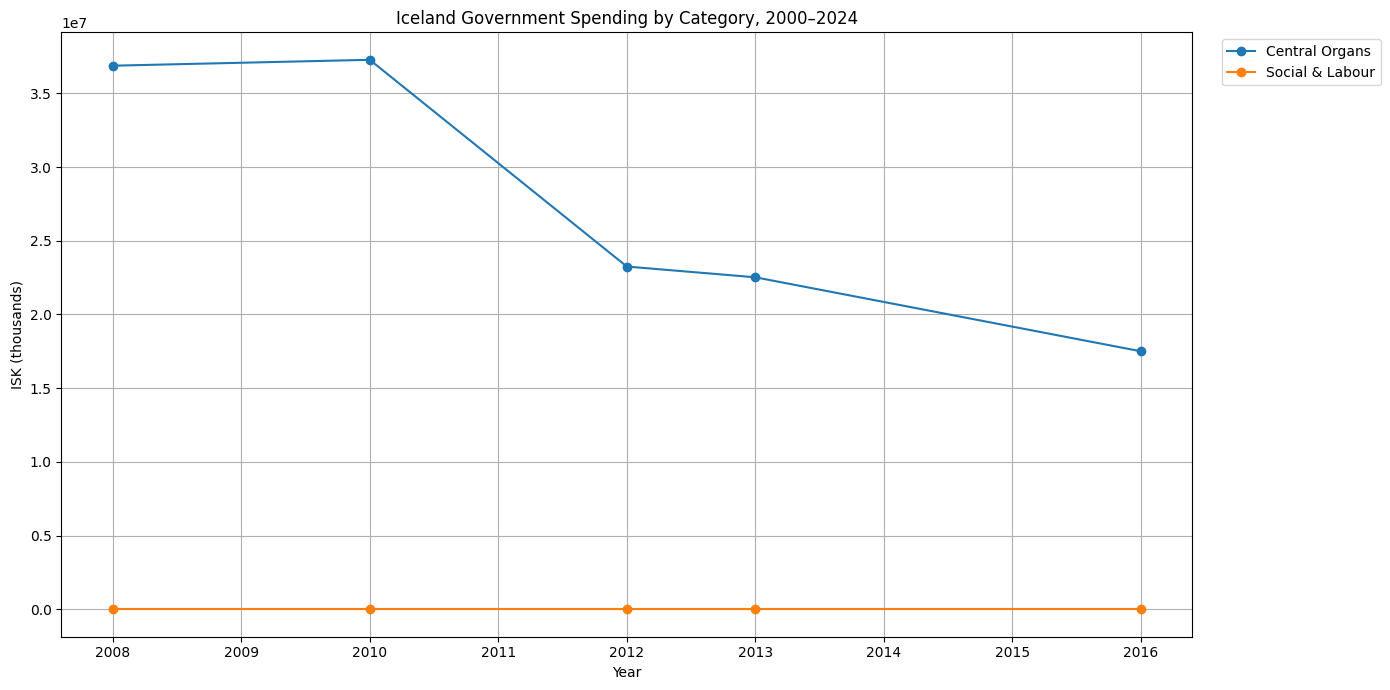

In [121]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your deduped master file
df = pd.read_csv("data/processed/all_years_normalized_deduped.csv")

# Ensure correct numeric types (some files store as str)
df["Amount_thousands_ISK"] = pd.to_numeric(df["Amount_thousands_ISK"], errors="coerce")
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

# Pivot table: total spending per category per year
pivot = df.pivot_table(
    index="Year",
    columns="normalized_category",
    values="Amount_thousands_ISK",
    aggfunc="sum",
    fill_value=0
)

# Plot: Each category as a line over years
pivot.plot(figsize=(14, 7), marker='o')
plt.title("Iceland Government Spending by Category, 2000–2024")
plt.ylabel("ISK (thousands)")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.grid()
plt.show()


In [122]:
print(df['normalized_category'].value_counts())
print(df['Year'].value_counts())


normalized_category
Central Organs             1580
Social & Labour             791
Agriculture & Fisheries       2
Name: count, dtype: int64
Year
2010.0    624
2012.0    570
2008.0    552
2013.0    480
2016.0    144
Name: count, dtype: int64


In [123]:
import pandas as pd
files = [f for f in os.listdir('data/normalized') if f.endswith('.csv')]
for fname in files:
    df = pd.read_csv(f'data/normalized/{fname}')
    print(fname, df['normalized_category'].value_counts(dropna=False))
    print(fname, df['Year'].value_counts(dropna=False))


Rikisreikn2009Heildaryfirlit_parsed_normalized.csv normalized_category
NaN             5746
Misc/Missing       7
Name: count, dtype: int64
Rikisreikn2009Heildaryfirlit_parsed_normalized.csv Year
2009    5753
Name: count, dtype: int64
Rikisreikn2009ArsreiknRikisadila_parsed_normalized.csv normalized_category
NaN             17401
Misc/Missing       44
Name: count, dtype: int64
Rikisreikn2009ArsreiknRikisadila_parsed_normalized.csv Year
2009    17445
Name: count, dtype: int64
Rikisreikningur-2011-arsreikningar-rikiisadila_parsed.csv normalized_category
NaN    17367
Name: count, dtype: int64
Rikisreikningur-2011-arsreikningar-rikiisadila_parsed.csv Year
2011    17367
Name: count, dtype: int64
Rikisreikningur-2020_parsed.csv normalized_category
NaN    7174
Name: count, dtype: int64
Rikisreikningur-2020_parsed.csv Year
2020    7174
Name: count, dtype: int64
Rikisreikningur-arid-2014-Arsreikningar-rikisadila_parsed_clean.csv normalized_category
NaN             16421
Misc/Missing       41
Nam

KeyError: 'Year'

In [124]:
import pandas as pd
import re

def is_likely_garbage(val):
    if pd.isna(val): return True
    s = str(val).strip()
    # Blank or short
    if not s or len(s) < 4: return True
    # Excessively numeric or punctuation
    if sum(c.isdigit() for c in s) > len(s) * 0.5: return True
    if s.replace(".", "").replace(",", "").replace("-", "").isdigit(): return True
    # Looks like a total or header
    if re.search(r"(gjöld|tekjur|samtals|ráðuneyti.*námu|samantekt|all[rs]s|millj)", s, re.I): return True
    # Too long (random OCR mush)
    if len(s) > 60: return True
    # Too many words
    if s.count(" ") > 8: return True
    return False

# Change path below as needed
unmapped_path = "data/unmapped_after_propagation.csv"
df = pd.read_csv(unmapped_path)
df["is_garbage"] = df["Ministry"].apply(is_likely_garbage)

# Keep only true "unknowns"
clean_unknowns = df[~df["is_garbage"]]
print(f"{len(clean_unknowns)} actual unmapped ministries after filtering out garbage.")

# Save to file for review
clean_unknowns.to_csv("data/unmapped_true_ministries.csv", index=False)
print("Saved: data/unmapped_true_ministries.csv")


1103 actual unmapped ministries after filtering out garbage.
Saved: data/unmapped_true_ministries.csv
